In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
import numpy as np


In [16]:
df = pd.read_csv('train.csv')

In [17]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [19]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhabd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhabd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [22]:
df['comment_text'] = df['comment_text'].apply(preprocess_text)

In [23]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he match this background colour i m seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestion on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df['comment_text'])


In [11]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df[labels].values

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [23]:
models = {
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=1000, penalty='l2', C=1.0)),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(max_depth=15, n_estimators=100, min_samples_split=2, min_samples_leaf=1)),
    'Multinomial NB': OneVsRestClassifier(MultinomialNB(alpha=1.0, fit_prior=True)),
    'DecisionTree': OneVsRestClassifier(DecisionTreeClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=1))
}


In [48]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

model_scores = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
    
    model_scores[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }
    
    print(f"Accuracy for {name}: {accuracy}")
    print(f"Precision for {name}: {precision}")
    print(f"Recall for {name}: {recall}\n")


Training Logistic Regression...
Evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.9208522638257872
Precision for Logistic Regression: 0.7472088567169525
Recall for Logistic Regression: 0.3910535579976784

Training Random Forest...
Evaluating Random Forest...
Accuracy for Random Forest: 0.8984490051699827
Precision for Random Forest: 0.9743589743589743
Recall for Random Forest: 0.00740685065908168

Training Multinomial NB...
Evaluating Multinomial NB...
Accuracy for Multinomial NB: 0.9114209619301269
Precision for Multinomial NB: 0.6250093768890146
Recall for Multinomial NB: 0.25328244753809825

Training DecisionTree...
Evaluating DecisionTree...
Accuracy for DecisionTree: 0.9104182986056714
Precision for DecisionTree: 0.6296253497621205
Recall for DecisionTree: 0.3806341199034298



In [51]:
model_scores

{'Logistic Regression': {'accuracy': 0.9208522638257872,
  'precision': 0.7472088567169525,
  'recall': 0.3910535579976784},
 'Random Forest': {'accuracy': 0.8984490051699827,
  'precision': 0.9743589743589743,
  'recall': 0.00740685065908168},
 'Multinomial NB': {'accuracy': 0.9114209619301269,
  'precision': 0.6250093768890146,
  'recall': 0.25328244753809825},
 'DecisionTree': {'accuracy': 0.9104182986056714,
  'precision': 0.6296253497621205,
  'recall': 0.3806341199034298}}

## Neural Network

In [24]:
from tensorflow.keras.layers import TextVectorization
num_of_words = 200000
vectorizer = TextVectorization(max_tokens=num_of_words,
                               output_sequence_length=1800,
                               output_mode='int')

In [25]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [26]:
vectorizer.adapt(X.values)

In [27]:
vectorized_text = vectorizer(X.values)

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [38]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
def create_model():
    model = Sequential()
    model.add(Embedding(num_of_words+1, 32))
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.compile(loss='BinaryCrossentropy', optimizer='Adam')
    return model

model = create_model()

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 6)                 774       
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

Epoch 1/10
6981/6981 [==============================] - 1665s 238ms/step - loss: 0.0541 - val_loss: 0.0435
Epoch 2/10
6981/6981 [==============================] - 1938s 278ms/step - loss: 0.0434 - val_loss: 0.0386
Epoch 3/10
6981/6981 [==============================] - 1860s 266ms/step - loss: 0.0380 - val_loss: 0.0346
Epoch 4/10
6981/6981 [==============================] - 1143s 164ms/step - loss: 0.0338 - val_loss: 0.0289
Epoch 5/10
6981/6981 [==============================] - 1241s 178ms/step - loss: 0.0301 - val_loss: 0.0251
Epoch 6/10
6981/6981 [==============================] - 1088s 156ms/step - loss: 0.0268 - val_loss: 0.0219
Epoch 7/10
6981/6981 [==============================] - 1089s 156ms/step - loss: 0.0233 - val_loss: 0.0185
Epoch 8/10
6981/6981 [==============================] - 1089s 156ms/step - loss: 0.0206 - val_loss: 0.0170
Epoch 9/10
6981/6981 [==============================] - 1086s 156ms/step - loss: 0.0182 - val_loss: 0.0146
Epoch 10/10
6981/6981 [==============

In [30]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

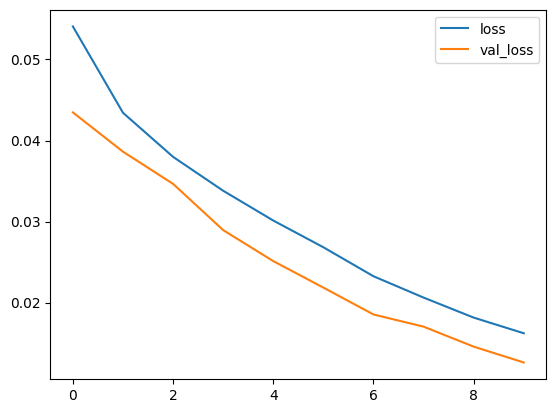

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [33]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [39]:
# model = tf.keras.models.load_model('my_model.h5')

In [40]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X_true, y_true = batch
    
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9331468343734741, Recall:0.9474580883979797, Accuracy:0.5576730370521545


In [ ]:
# model.save('my_model.h5')

1/1 [==============================] - 0s 77ms/step


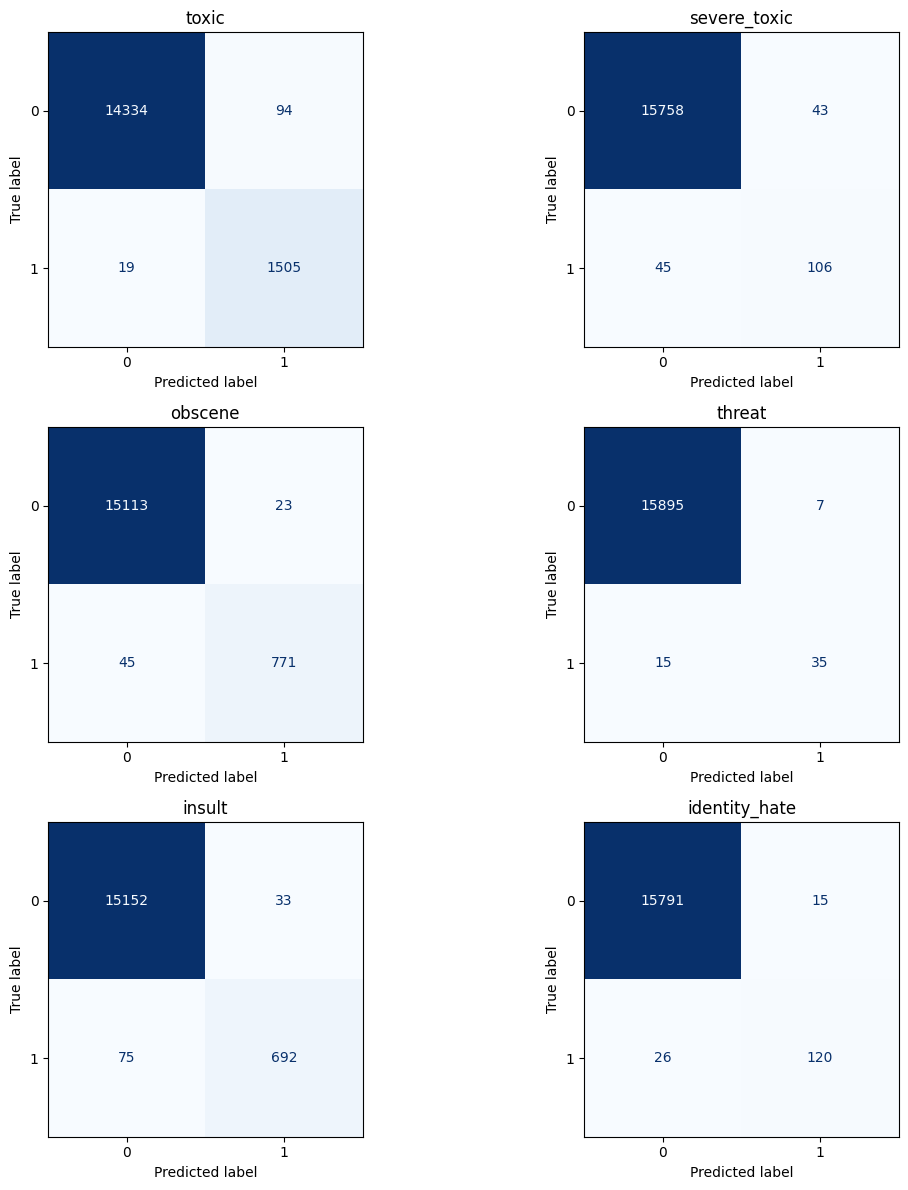

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_true = []
y_pred = []

for batch in test:
    X_batch, y_batch = batch
    predictions = model.predict(X_batch)
    y_true.extend(y_batch)
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

y_pred_binary = (y_pred > 0.5).astype(int)


conf_matrices = multilabel_confusion_matrix(y_true, y_pred_binary)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, (label, cm) in enumerate(zip(labels, conf_matrices)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(label)

plt.tight_layout()
plt.show()